In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Acc and ECE

In [44]:
dataset = "bloodmnist_epoch_150_adam"
test_dir = f"./runs/{dataset}/test"

df = pd.DataFrame(columns=["seed", "experiment_type", "num_labeled", "test_acc", "test_loss", "test_ece"])

for i in range(5):
    seed_dir = f"{test_dir}/seed_{i+1}"
    for folder in os.listdir(seed_dir):
        if folder == 'untrained':
            continue
        exp_type, num_labeled = folder.split("_")

        test_metrics = pd.read_csv(f"{seed_dir}/{folder}/test_metrics.csv")
        
        test_acc = test_metrics["test_acc"].values[-1]
        test_loss = test_metrics["test_loss"].values[-1]
        test_ece = test_metrics["test_ece"].values[-1]

        df.loc[len(df)] = {
                "seed": i + 1,
                "experiment_type": exp_type,
                "num_labeled": int(num_labeled),
                "test_acc": test_acc,
                "test_loss": test_loss,
                "test_ece": test_ece }
         
        df = df.sort_values(by=["seed","experiment_type", "num_labeled"])

In [45]:
df.to_csv(f"{test_dir}/test_metrics.csv", index=False)
results = df 

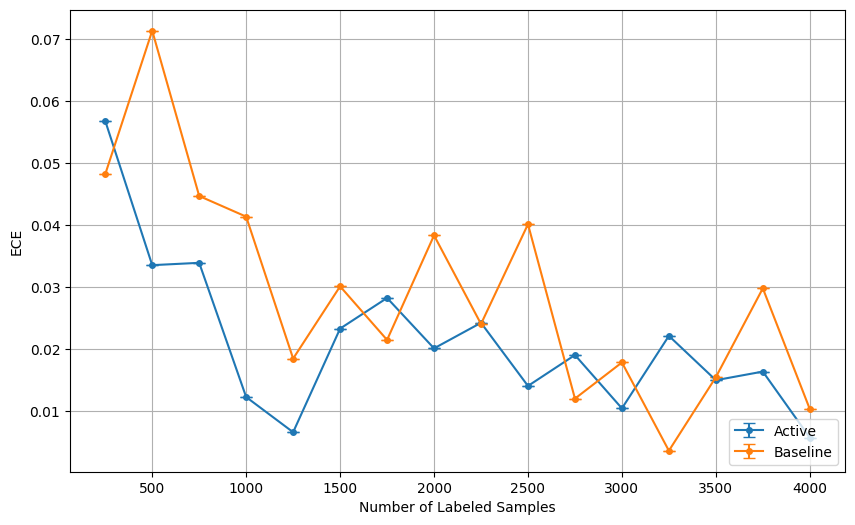

In [46]:
metrics_columns = ["test_acc", "test_loss", "test_ece"]

# Group by 'num_labeled' and 'experiment_type' columns and calculate the standard deviation for each metric
stddev_by_num_labeled = df.groupby(["num_labeled", "experiment_type"])[metrics_columns].std().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot accuracy vs. num_labeled for active with error bars
active_data = stddev_by_num_labeled[stddev_by_num_labeled["experiment_type"] == "active"]

plt.errorbar(
    x=active_data["num_labeled"],
    y=results[(results["experiment_type"] == "active") & (results["seed"] == 1)]["test_ece"],
    yerr=active_data["test_ece"],
    fmt="o-",
    label="Active",
    capsize=4,
    markersize=4,
)

# Plot accuracy vs. num_labeled for baseline with error bars
baseline_data = stddev_by_num_labeled[stddev_by_num_labeled["experiment_type"] == "baseline"]

plt.errorbar(
    x=baseline_data["num_labeled"],
    y=results[(results["experiment_type"] == "baseline") & (results["seed"] == 1)]["test_ece"],
    yerr=baseline_data["test_ece"],
    fmt="o-",
    label="Baseline",
    capsize=4,
    markersize=4,
)

plt.xlabel("Number of Labeled Samples")
plt.ylabel("ECE")


plt.legend(loc="lower right")
plt.grid()
plt.show()

In [47]:
stddev_by_num_labeled = df.groupby(["num_labeled", "experiment_type"])[metrics_columns].std().reset_index()
stddev_by_num_labeled = stddev_by_num_labeled[stddev_by_num_labeled["experiment_type"] == "active"]
stddev_by_num_labeled

,num_labeled,experiment_type,test_acc,test_loss,test_ece
0,250,active,0.0,1.715246e-07,2.013923e-08
2,500,active,0.0,1.675348e-07,3.548862e-08
4,750,active,0.0,1.413879e-07,4.947173e-08
6,1000,active,0.0,1.064302e-07,4.402631e-08
8,1250,active,0.0,9.382399e-08,4.644225e-08
10,1500,active,0.0,1.414707e-07,2.431692e-08
12,1750,active,0.0,1.694866e-07,2.019191e-08
14,2000,active,0.0,6.119445e-08,4.041877e-08
16,2250,active,0.0,1.196513e-07,1.020175e-08
18,2500,active,0.0,7.148717e-08,3.286023e-08


In [48]:
acc_per_class_df = pd.DataFrame(columns=["seed", "experiment_type", "num_labeled", "acc_per_class"])

for i in range(5):
    seed_dir = f"{test_dir}/seed_{i+1}"
    for folder in os.listdir(seed_dir):
        if folder == "untrained":
            continue

        exp_type, num_labeled = folder.split("_")

        accs = pd.read_csv(f"{seed_dir}/{folder}/accuracy_per_class.csv")

        values_dict = {}
        for col in accs.columns:
            values_dict[col] = accs[col].values[0]

        acc_per_class_df.loc[len(acc_per_class_df)] = {
            "seed": i + 1,
            "experiment_type": exp_type,
            "num_labeled": int(num_labeled),
            "acc_per_class": values_dict,
        }

In [49]:
class_dist_df = pd.DataFrame(columns=["seed", "experiment_type", "num_labeled", "class_distribution"])

for i in range(5):
    seed_dir = f"{test_dir}/seed_{i+1}"
    for folder in os.listdir(seed_dir):
        exp_type, num_labeled = folder.split("_")

        accs = pd.read_csv(f"{seed_dir}/{folder}/class_distribution.csv")

        values_dict = {}
        # iterate over rows in the dataframe and add the values to the dictionary
        for index, row in accs.iterrows():
            values_dict[row["Class"]] = row["Num Samples"]

        class_dist_df.loc[len(class_dist_df)] = {
            "seed": i + 1,
            "experiment_type": exp_type,
            "num_labeled": int(num_labeled),
            "class_distribution": values_dict,
        }

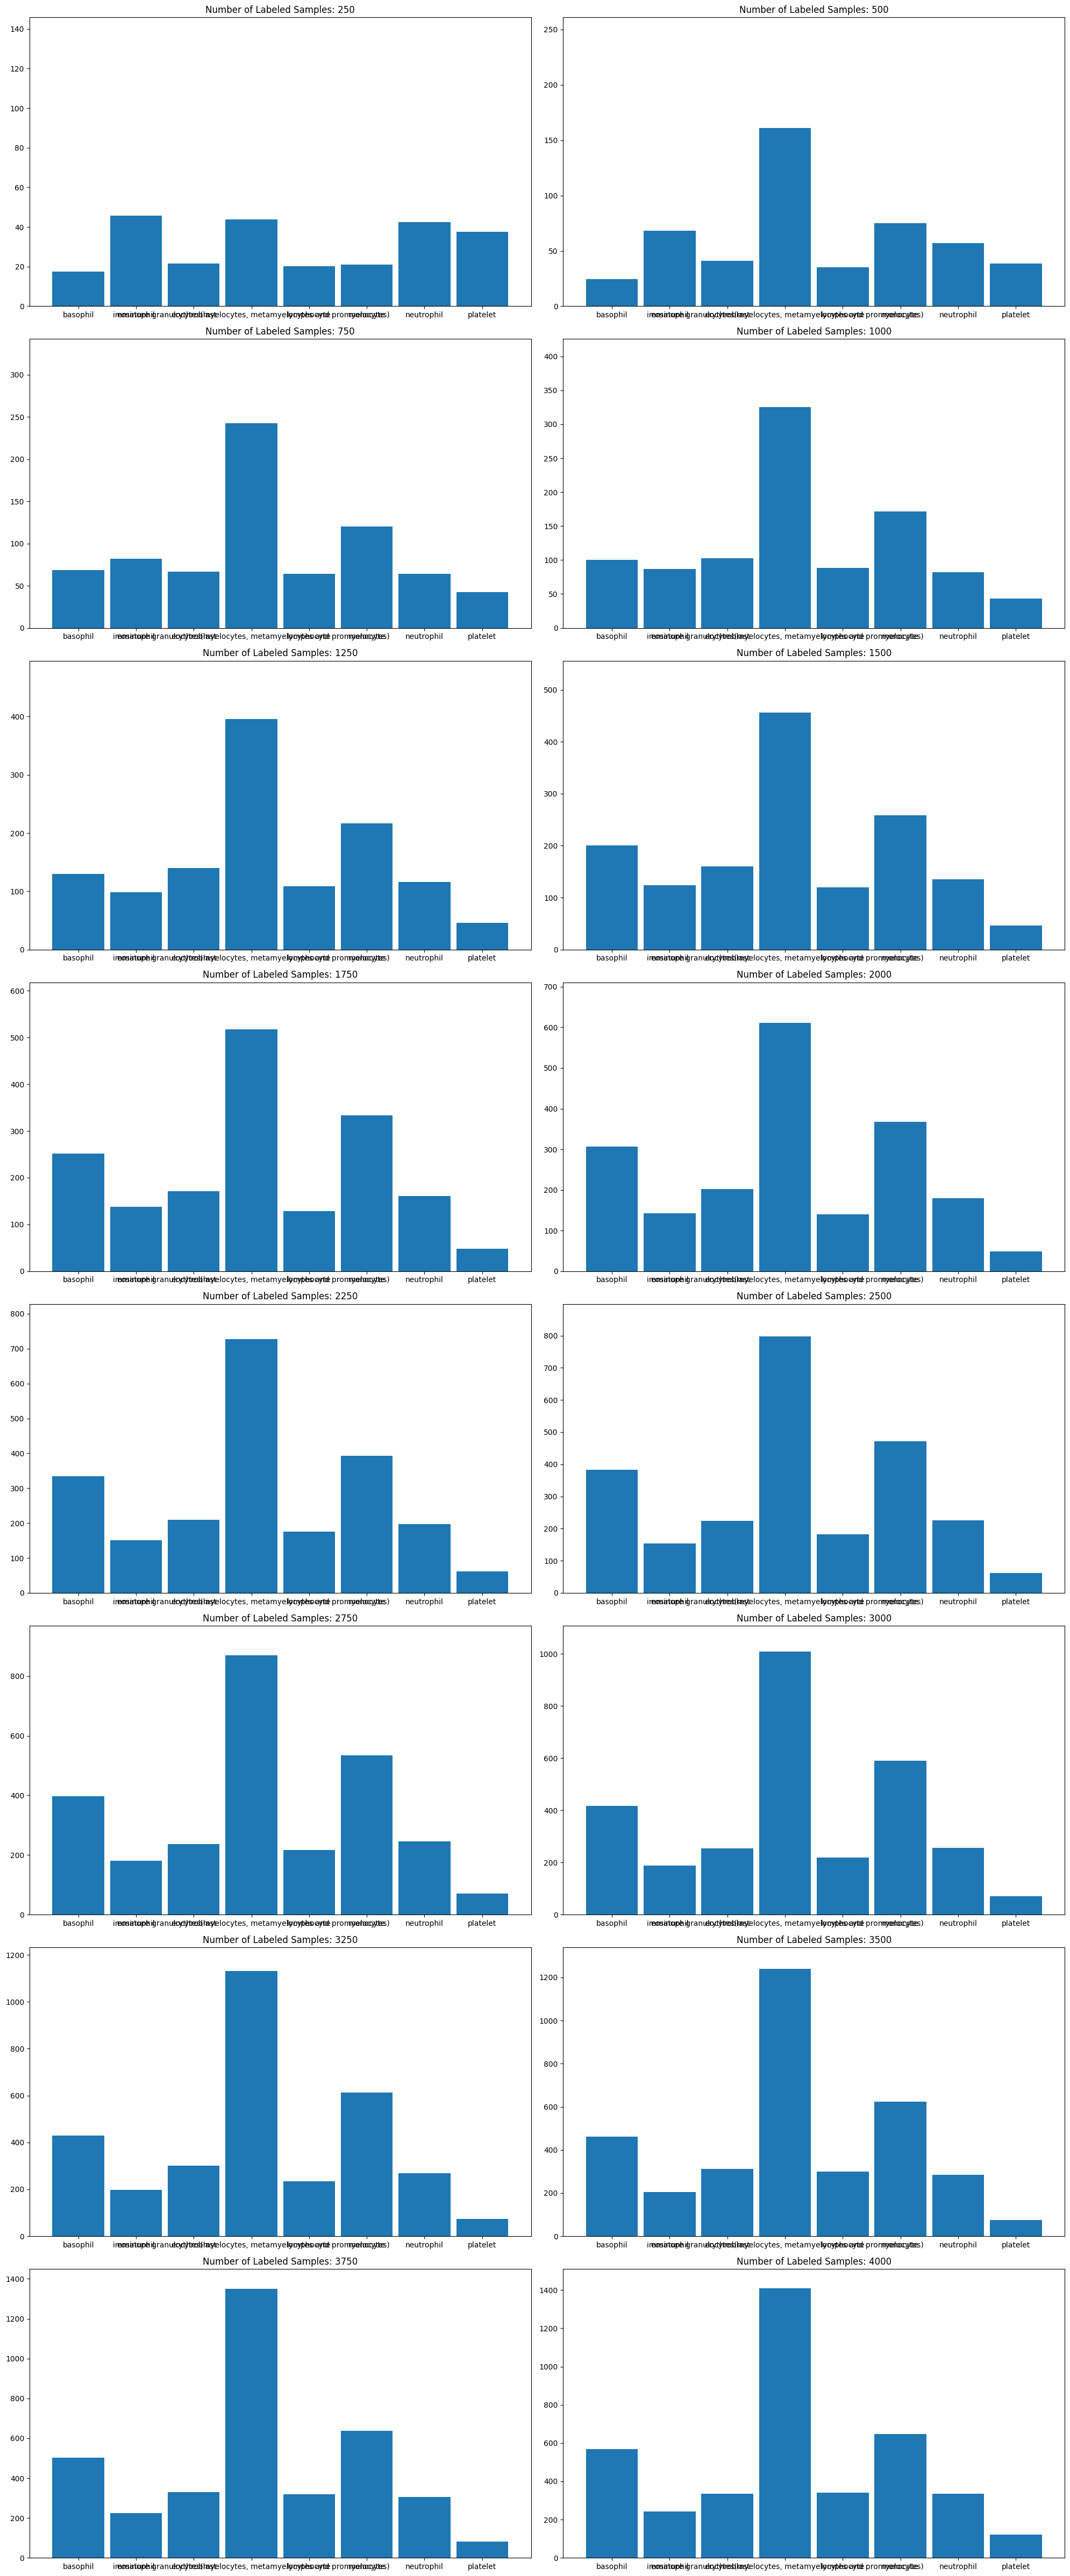

In [50]:
# Assuming 'df_acc_per_class' is your DataFrame
# Sort the DataFrame by 'num_labeled' for plotting
df_acc_per_class_sorted = class_dist_df[class_dist_df['experiment_type']=='active'].sort_values(by=["num_labeled"])

# Get unique experiment types
experiment_types = df_acc_per_class_sorted["experiment_type"].unique()

# Get the list of classes from the first row (assuming all rows have the same classes)
classes = list(df_acc_per_class_sorted["class_distribution"].iloc[0].keys())

# Get unique num_labeled values
num_labeled_values = df_acc_per_class_sorted["num_labeled"].unique()

# Calculate the number of subplots needed
num_subplots = len(num_labeled_values)

# Define the number of columns in the subplot grid
num_cols = 2  # You can adjust this based on your preference

# Calculate the number of rows in the subplot grid
num_rows = int(np.ceil(num_subplots / num_cols))

# Plotting
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))

# Iterate over num_labeled values
for i, num_labeled in enumerate(num_labeled_values):
    # Determine the subplot position
    if num_rows > 1:
        ax = axes[i // num_cols, i % num_cols]
    else:
        ax = axes[i % num_cols]

    # Iterate over experiment types
    for j, experiment_type in enumerate(experiment_types):
        # Get the mean accuracy for each class
        acc_values = np.array(
            [
                df_acc_per_class_sorted[
                    (df_acc_per_class_sorted["num_labeled"] == num_labeled) & (df_acc_per_class_sorted["experiment_type"] == experiment_type)
                ]["class_distribution"]
                .apply(lambda x: x[class_name])
                .mean()
                for class_name in classes
            ]
        )

        # Plotting a single group of bars for each experiment type and num_labeled value
        bar_width = 0.9
        ax.bar(np.arange(len(classes)) + j * bar_width, acc_values, width=bar_width, label=f"{experiment_type}")

    ax.set_title(f"Number of Labeled Samples: {num_labeled}")
    ax.set_xticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_ylim(0, np.max(acc_values) + 100)

plt.tight_layout()
plt.show()

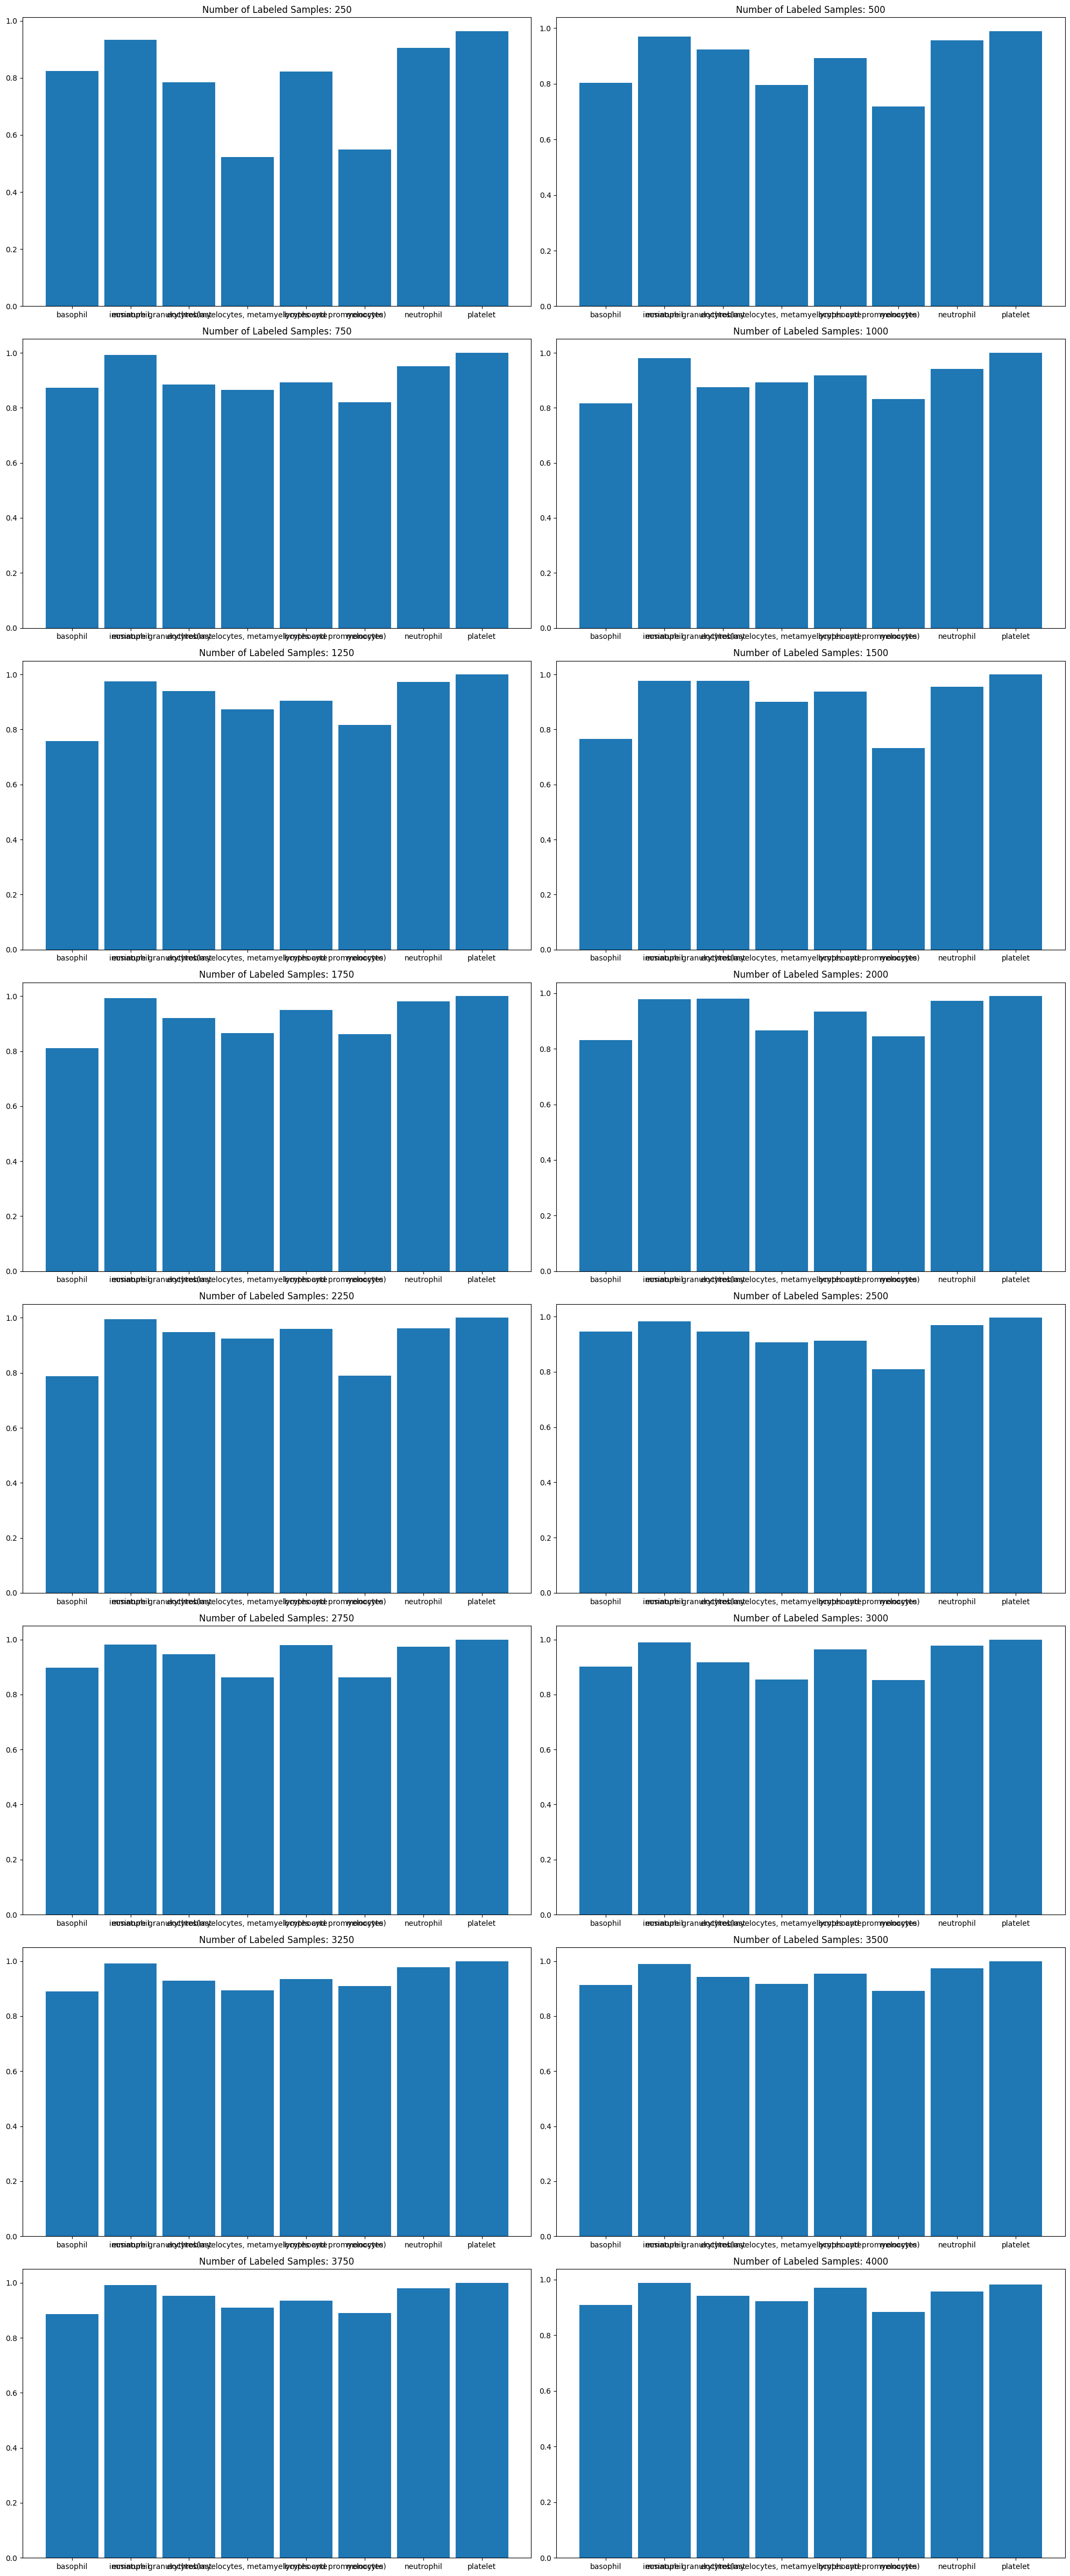

In [51]:
# Filter DataFrame to only include rows where 'experiment_type' is 'active'
df_acc_per_class_sorted = acc_per_class_df[acc_per_class_df['experiment_type'] == 'active'].sort_values(by=["num_labeled"])

# Get unique experiment types
experiment_types = df_acc_per_class_sorted["experiment_type"].unique()

# Get the list of classes from the first row (assuming all rows have the same classes)
classes = list(df_acc_per_class_sorted["acc_per_class"].iloc[0].keys())

# Get unique num_labeled values
num_labeled_values = df_acc_per_class_sorted["num_labeled"].unique()

# Calculate the number of subplots needed
num_subplots = len(num_labeled_values)

# Define the number of columns in the subplot grid
num_cols = 2  # You can adjust this based on your preference

# Calculate the number of rows in the subplot grid
num_rows = int(np.ceil(num_subplots / num_cols))

# Plotting
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))

# Iterate over num_labeled values
for i, num_labeled in enumerate(num_labeled_values):
    # Determine the subplot position
    if num_rows > 1:
        ax = axes[i // num_cols, i % num_cols]
    else:
        ax = axes[i % num_cols]

    # Iterate over experiment types
    for j, experiment_type in enumerate(experiment_types):
        # Get the mean accuracy for each class
        acc_values = np.array(
            [
                df_acc_per_class_sorted[
                    (df_acc_per_class_sorted["num_labeled"] == num_labeled) & (df_acc_per_class_sorted["experiment_type"] == experiment_type)
                ]["acc_per_class"]
                .apply(lambda x: x[class_name])
                .mean()
                for class_name in classes
            ]
        )

        # Plotting a single group of bars for each experiment type and num_labeled value
        bar_width = 0.9
        ax.bar(np.arange(len(classes)) + j * bar_width, acc_values, width=bar_width, label=f"{experiment_type}")

    ax.set_title(f"Number of Labeled Samples: {num_labeled}")
    ax.set_xticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)

plt.tight_layout()
plt.show()